In [92]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.utils import shuffle

In [93]:
np.random.seed(42)
nn = 600
cat_images = np.random.randn(nn, 2) + np.array([3, -3])
mouse_images = np.random.randn(nn, 2) + np.array([3, 3])
#dog_images = np.random.randn(nn, 2) + np.array([-3, 3])
#frog_images = np.random.randn(nn, 2) + np.array([-3, -3])

feature_set = np.vstack([cat_images, mouse_images])#, dog_images, frog_images
labels = np.array([0]*nn + [1]*nn)# + [2]*nn + [3]*nn
feature_set, labels = shuffle(np.array(feature_set), np.array(labels))



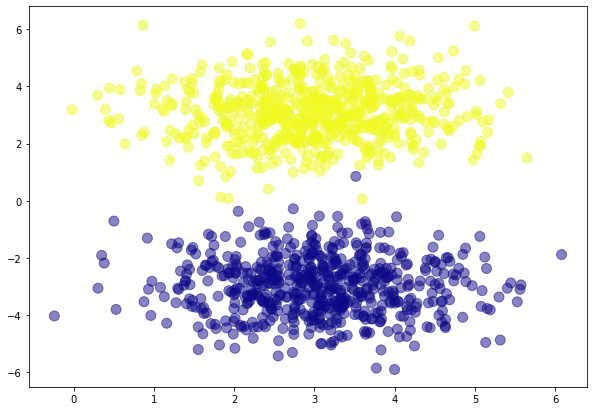

In [94]:
plt.figure(figsize=(10,7))
plt.scatter(feature_set[:,0], feature_set[:,1], c=labels, cmap='plasma', s=100, alpha=0.5)
plt.show()


In [95]:
class SimpleDataEnv():
    def __init__(self, images_per_episode=1, dataset=(feature_set, labels), random=True):
        self.images_per_episode = images_per_episode
        self.step_count = 0
        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):
        done = False
        if action == self.expected_action:
            reward = 1
        else:
            reward = -3

        obs = self._next_obs()
        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, self.expected_action

    def reset(self):
        self.step_count = 0
        obs = self._next_obs()
        return obs, self.expected_action

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]

        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs


In [96]:
class Estimator():
    def __init__(self, n_state, lr=0.001):
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, 1),
                        torch.nn.Sigmoid()
                )
        self.criterion = torch.nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def predict(self, s):
        return self.model(torch.Tensor(s))

    def update(self, s, y):
        """
        Update the weights of the estimator given the training samples
        """
        y_pred = self.predict(s)
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)).unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



In [97]:
def cross_entropy(env, estimator, n_episode, n_samples):
    experience = []
    for episode in range(n_episode):
        rewards = 0
        actions = []
        states = []
        state, action = env.reset()
        while True:
            states.append(state)
            actions.append(action)
            next_state, reward, is_done, next_action = env.step(action)
            rewards += reward

            if is_done:
                for state, action in zip(states, actions):
                    experience.append((rewards, state, action))
                break

            state = next_state
            action = next_action

    experience = sorted(experience, key=lambda x: x[0], reverse=True)
    select_experience = experience[:n_samples]
    train_states = [exp[1] for exp in select_experience]
    train_actions = [exp[2] for exp in select_experience]

    for _  in range(100):
        estimator.update(train_states, train_actions)


In [98]:
env = SimpleDataEnv(images_per_episode=1)
n_state = 2
lr = 0.01
estimator = Estimator(n_state, lr)

In [99]:
n_episode = 5000
n_samples = 10000

cross_entropy(env, estimator, n_episode, n_samples)


In [100]:

n_episode = 100
total_reward_episode = [0] * n_episode
for episode in range(n_episode):
    state, action = env.reset()
    is_done = False
    while not is_done:
        action = 1 if estimator.predict(state).item() >= 0.5 else 0
        next_state, reward, is_done, next_action = env.step(action)
        total_reward_episode[episode] += reward
        state = next_state


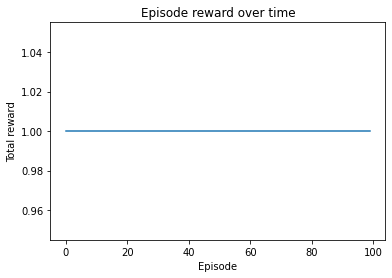

In [101]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()